# Task 6 - Advanced Models

In [ ]:
from ift6758.data.nhl_data_parser import NHLDataParser
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
import os
from imblearn.under_sampling import RandomUnderSampler
import wandb
from ift6758.data.data_logger import DataLogger
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC,SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# Load the data
data_parser = NHLDataParser()
train_df = data_parser.get_shot_and_goal_pbp_df_for_seasons(2016, 2019, with_playoff_season=False)
test_df = data_parser.get_shot_and_goal_pbp_df_for_season(2020, with_playoff_season=False)

In [ ]:
#Columns
for column in train_df.columns:
    print(column)

In [ ]:
#default values
project_name = "IFT6758.2024-B08"
entity_name = "team08"
dir_path = os.getenv('WANDB_DIR')


In [ ]:
train_df

In [ ]:
#Data Preprocessing
def preprocess_data(train_df,scaling = False):
    dropped_columns = ['gameId',
                   'timeRemaining',
                   'periodNumber',
                   'timeInPeriod',
                   'xCoord',
                   'yCoord',
                   'zoneCode',
                   'shootingTeam',
                   'shootingPlayer',
                   'previousEventX',
                   'previousEventY',
                   'goalieInNet',
                   'shootingTeamSide',
                   ]
    numeric_columns = ['shotDistance',
                       'shotAngle',
                       'timeDiff',
                       'distanceDiff',
                       'shotAngleDiff',
                       'speed']
    train_df_clean = train_df.drop(columns=dropped_columns)

    #Drop rows with missing values
    train_df_clean = train_df_clean.dropna()
    
    #scale the numerical columns
    if scaling:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        train_df_clean[numeric_columns] = scaler.fit_transform(train_df_clean[numeric_columns])
    
   

    #one hot encoding
    train_df_clean = pd.get_dummies(train_df_clean,columns = ['shotType','previousEvent'])

    
    
    return train_df_clean






## Decision Tree

In [25]:
# load path and make dirs to store model
model_path = os.getenv("MODEL_PATH") #edit .env file to change path
tree_path = os.path.join(model_path, "decision_tree")
if not os.path.exists(tree_path):
    os.makedirs(tree_path)


In [ ]:

# Define the sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'roc_auc_score',
        'goal': 'maximize'
    },
    'parameters': {
        'criterion': {
            'values': ['entropy']
        },
        'splitter': {
            'values': ['best', 'random']
        },
        'max_depth': {
            'values': [10,20,30,40,50,60,70,80,90,100]
        },
        'min_samples_split': {
            'values': [2, 5, 10]
        },
        'min_samples_leaf': {
            'values': [1, 2, 4]
        },
        'max_features': {
            'values': ['sqrt', 'log2']
        }
        
    }
}

# Define the training function
def train_tree(config=None): 
    # Initialize a new wandb run
    with wandb.init(dir=dir_path, 
                    group='decision_tree',
                    job_type='hyperparameter_sweep',
                    name=f'decision_trees_undersampled_old_features'):

        # Get the hyperparameters
        config = wandb.config

        # # Preprocess the data
        # train_df_clean = preprocess_data(train_df,scaling = False)

        train_df_clean = train_df[['isGoal','shotAngle','shotDistance']]
      

       # Split the data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(train_df_clean.drop(columns='isGoal'), train_df_clean['isGoal'], test_size=0.3, stratify=train_df_clean['isGoal'])

        
        # Under sample the training data
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    
        # Initialize the model
        model = DecisionTreeClassifier(
            criterion=config.criterion,
            splitter=config.splitter,
            max_depth=config.max_depth,
            min_samples_split=config.min_samples_split,
            min_samples_leaf=config.min_samples_leaf,
            max_features=config.max_features
        )

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_val)

        # Calculate metrics
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred)
        avg_precision = average_precision_score(y_val, y_pred)

        # Log metrics to wandb
        wandb.log({
            'precision_score': precision,
            'recall_score': recall,
            'f1_score': f1,
            'roc_auc_score': roc_auc,
            'average_precision_score': avg_precision
        })
        

   




In [ ]:
sweep_id = wandb.sweep(sweep_config, project=project_name, entity=entity_name)
wandb.agent(sweep_id, function=train_tree, count=100)
wandb.teardown()

In [36]:
#Test best model on val data

# Preprocess the data
test_df_clean = preprocess_data(test_df)
train_df_clean = preprocess_data(train_df)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df_clean.drop(columns='isGoal'), train_df_clean['isGoal'], test_size=0.3, stratify=train_df_clean['isGoal'])

# Under sample the training data
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

clf_dtree = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2', min_samples_leaf=5, min_samples_split=5, splitter='best')
clf_dtree.fit(X_train, y_train)
predictions = clf_dtree.predict(X_val)
predictions_proba_tree = clf_dtree.predict_proba(X_val)[:,1]
y_val_dtree = y_val
print(roc_auc_score(y_val, predictions))
model_3_path = os.path.join(tree_path, "decision_tree_undersample_newfeatures.pkl")
with open(model_3_path, 'wb') as f:
    pickle.dump(clf_dtree, f)




0.6846180269948912


## SVM

In [27]:
# load path and make dirs to store model
model_path = os.getenv("MODEL_PATH") #edit .env file to change path
svm_path = os.path.join(model_path, "svm")
if not os.path.exists(svm_path):
    os.makedirs(svm_path)

In [ ]:
#Define the sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'roc_auc_score',
        'goal': 'maximize'
    },
    'parameters': {
        'C': {
            'values': [0.001, 0.01, 0.1, 1, 10, 100]
        },
        'loss': {
            'values': ['hinge', 'squared_hinge']
        },
        'penalty': {
            'values': ['l2', 'l1']
        },
        'class_weight': {
            'values': ['balanced']
        },
        'max_iter': {
            'values': [1500]
        }
    }
}

# Define the training function
def train_linearSVC(config=None):
    # Initialize a new wandb run
    with wandb.init(dir=dir_path, 
                    group='svc',
                    job_type='hyperparameter_sweep',
                    name=f'linear_svc_balanced_new_features_kfold'):

        # Get the hyperparameters
        config = wandb.config

        # Preprocess the data
        train_df_clean = preprocess_data(train_df,scaling = True)

        

        # # Under sample the training data
        # rus = RandomUnderSampler(random_state=42)
        # X_train, y_train = rus.fit_resample(X_train, y_train)

       

        # Initialize the model with normalization
        model = LinearSVC(
            C=config.C,
            loss=config.loss,
            penalty=config.penalty,
            class_weight=config.class_weight,
            max_iter=config.max_iter
        )

        X = train_df_clean.drop(columns='isGoal')
        y = train_df_clean['isGoal']
       
        #Kfold cross validation
        cv_results = cross_validate(model, X, y, cv=5, scoring=['roc_auc','f1','precision','recall'])
        

        # Calculate metrics
        precision = cv_results['test_precision'].mean()
        recall = cv_results['test_recall'].mean()
        f1 = cv_results['test_f1'].mean()
        roc_auc = cv_results['test_roc_auc'].mean()
        

        # Log metrics to wandb
        wandb.log({
            'precision_score': precision,
            'recall_score': recall,
            'f1_score': f1,
            'roc_auc_score': roc_auc
        })

In [ ]:
# Initialize the sweep
wandb.teardown()
sweep_id = wandb.sweep(sweep_config, project=project_name, entity=entity_name)
wandb.agent(sweep_id, function=train_linearSVC, count=20)

In [35]:
#Test best model on val data

# Preprocess the data
test_df_clean = preprocess_data(test_df,scaling=True)
train_df_clean = preprocess_data(train_df,scaling=True)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df_clean.drop(columns='isGoal'), train_df_clean['isGoal'], test_size=0.2, stratify=train_df_clean['isGoal'])

#Make pipeline
model =  LinearSVC(C=0.01, class_weight='balanced', loss='squared_hinge', max_iter=1500, penalty='l1')
model.fit(X_train, y_train)
predictions = model.predict(X_val)
predictions_proba_svm = model.decision_function(X_val)
y_val_svm = y_val
print(roc_auc_score(y_val, predictions))
model_4_path = os.path.join(svm_path, "linearSvc_balanced_Kfold_newfeatures.pkl")
with open(model_4_path, 'wb') as f:
    pickle.dump(model, f)

0.7017825512288972


In [ ]:
#SVC
#Define the sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'roc_auc_score',
        'goal': 'maximize'
    },
    'parameters': {
        'C': {
            'values': list(np.logspace(-3, 2, 6))
        },
        'kernel': {
            'values': [ 'poly', 'rbf', 'sigmoid']
        },
        'degree': {
            'values': [2, 3, 4, 5]
        },
        'gamma': {
            'values': ['scale', 'auto'] + list(np.logspace(-3, 2, 6))
        },
        'class_weight': {
            'values': ['balanced']
        },
        'probability': {
            'values': [True]
        },
        'cache_size': {
            'values': [500]
        },
        'max_iter': {
            'values': [1500]
    }
}}

# Define the training function
def train_SVC(config=None):
    # Initialize a new wandb run
    with wandb.init(dir=dir_path, 
                    group='svc',
                    job_type='hyperparameter_sweep',
                    name=f'svc_balanced_new_features_kfold'):

        # Get the hyperparameters
        config = wandb.config

        # Preprocess the data
        train_df_clean = preprocess_data(train_df,scaling=True)

        # # Under sample the training data
        # rus = RandomUnderSampler(random_state=42)
        # X_train, y_train = rus.fit_resample(X_train, y_train)

        # Initialize the model with normalization
        model = SVC(
            C=config.C,
            kernel=config.kernel,
            degree=config.degree,
            gamma=config.gamma,
            class_weight=config.class_weight,
            probability=config.probability,
            cache_size=config.cache_size,
            max_iter=config.max_iter
        )

        X = train_df_clean.drop(columns='isGoal')
        y = train_df_clean['isGoal']
       
        #Kfold cross validation
        cv_results = cross_validate(model, X, y, cv=5, scoring=['roc_auc','f1','precision','recall'])
        

        # Calculate metrics
        precision = cv_results['test_precision'].mean()
        recall = cv_results['test_recall'].mean()
        f1 = cv_results['test_f1'].mean()
        roc_auc = cv_results['test_roc_auc'].mean()
        

        # Log metrics to wandb
        wandb.log({
            'precision_score': precision,
            'recall_score': recall,
            'f1_score': f1,
            'roc_auc_score': roc_auc
        })

In [ ]:
# Initialize the sweep
wandb.teardown()
sweep_id = wandb.sweep(sweep_config, project=project_name, entity=entity_name)
wandb.agent(sweep_id, function=train_SVC, count=200)

In [34]:
#Test best model on val data

# Preprocess the data
test_df_clean = preprocess_data(test_df,scaling=True)
train_df_clean = preprocess_data(train_df,scaling=True)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df_clean.drop(columns='isGoal'), train_df_clean['isGoal'], test_size=0.2, stratify=train_df_clean['isGoal'])

#Make model
model = SVC(C=0.01, probability=True,max_iter=100)
model.fit(X_train, y_train)
predictions = model.predict(X_val)
predictions_proba_svc = model.decision_function(X_val)
y_val_svc = y_val
print(roc_auc_score(y_val, predictions))
model_5_path = os.path.join(svm_path, "svc_balanced_Kfold_newfeatures.pkl")
with open(model_5_path, 'wb') as f:
    pickle.dump(model, f)



c:\Users\gogig\micromamba\envs\ift6758-conda-env\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.5277942981669326


## Logistic Regression

In [ ]:
# load path and make dirs to store model
model_path = os.getenv("MODEL_PATH") #edit .env file to change path
logistic_path = os.path.join(model_path, "logistic_regression")
if not os.path.exists(logistic_path):
    os.makedirs(logistic_path)

In [ ]:
#Define the sweep configuration
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'roc_auc_score',
        'goal': 'maximize'
    },
    'parameters': {
        'C': {
            'values': list(np.logspace(-3, 2, 6))
        },
        'penalty': {
            'values': ['l1', 'l2', 'elasticnet', 'none']
        },
        'class_weight': {
            'values': ['balanced', None]
        },
        'solver': {
            'values': ['liblinear','saga','newton-cholesky']
        },
        'max_iter': {
            'values': [150]
        }
    }
}

# Define the training function
def train_logistic(config=None):
    # Initialize a new wandb run
    with wandb.init(dir=dir_path, 
                    group='logistic',
                    job_type='hyperparameter_sweep',
                    name=f'logistic_new_features_kfold'):

        # Get the hyperparameters
        config = wandb.config

        # Preprocess the data
        train_df_clean = preprocess_data(train_df,scaling=True)

        # # Under sample the training data
        # rus = RandomUnderSampler(random_state=42)
        # X_train, y_train = rus.fit_resample(X_train, y_train)

        # Initialize the model with normalization
        model = LogisticRegression(
            C=config.C,
            penalty=config.penalty,
            class_weight=config.class_weight,
            solver=config.solver,
            max_iter=config.max_iter
        )

        X = train_df_clean.drop(columns='isGoal')
        y = train_df_clean['isGoal']
       
        #Kfold cross validation
        cv_results = cross_validate(model, X, y, cv=5, scoring=['roc_auc','f1','precision','recall'])
        

        # Calculate metrics
        precision = cv_results['test_precision'].mean()
        recall = cv_results['test_recall'].mean()
        f1 = cv_results['test_f1'].mean()
        roc_auc = cv_results['test_roc_auc'].mean()
        

        # Log metrics to wandb
        wandb.log({
            'precision_score': precision,
            'recall_score': recall,
            'f1_score': f1,
            'roc_auc_score': roc_auc
        })

In [33]:
#Test best model on val data

# Preprocess the data
test_df_clean = preprocess_data(test_df,scaling=True)
train_df_clean = preprocess_data(train_df,scaling=True)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df_clean.drop(columns='isGoal'), train_df_clean['isGoal'], test_size=0.2, stratify=train_df_clean['isGoal'])

#Make model
model = LogisticRegression(C=0.01, class_weight='balanced', max_iter=150, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)
predictions = model.predict(X_val)
predictions_proba_logistic = model.predict_proba(X_val)[:,1]
y_val_log = y_val
print(roc_auc_score(y_val, predictions))
model_6_path = os.path.join(logistic_path, "logistic_newfeatures.pkl")
with open(model_6_path, 'wb') as f:
    pickle.dump(model, f)
    

0.6909202916766817


# Random Forest

In [ ]:
# load path and make dirs to store model
model_path = os.getenv("MODEL_PATH") #edit .env file to change path
rf_path = os.path.join(model_path, "random_forest")
if not os.path.exists(rf_path):
    os.makedirs(rf_path)
    

In [ ]:
#Define the sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'roc_auc_score',
        'goal': 'maximize'
    },
    'parameters': {
        'n_estimators': {
            'values': [10, 50, 100, 200, 500]
        },
        'criterion': {
            'values': ['entropy']
        },
        'max_depth': {
            'values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        },
        'min_samples_split': {
            'values': [2, 5, 10]
        },
        'min_samples_leaf': {
            'values': [1, 2, 4]
        },
        'max_features': {
            'values': ['sqrt', 'log2']
        },
        'class_weight': {
            'values': ['balanced','balanced_subsample', None]
        }
    }
}

# Define the training function
def train_rf(config=None):
    # Initialize a new wandb run
    with wandb.init(dir=dir_path, 
                    group='random_forest',
                    job_type='hyperparameter_sweep',
                    name=f'random_forest_balanced_new_features_kfold'):

        # Get the hyperparameters
        config = wandb.config

        # Preprocess the data
        train_df_clean = preprocess_data(train_df)

        # # Under sample the training data
        # rus = RandomUnderSampler(random_state=42)
        # X_train, y_train = rus.fit_resample(X_train, y_train)

        # Initialize the model with normalization
        model = RandomForestClassifier(
            n_estimators=config.n_estimators,
            criterion=config.criterion,
            max_depth=config.max_depth,
            min_samples_split=config.min_samples_split,
            min_samples_leaf=config.min_samples_leaf,
            max_features=config.max_features,
            class_weight=config.class_weight
        )

        X = train_df_clean.drop(columns='isGoal')
        y = train_df_clean['isGoal']
       
        #Kfold cross validation
        cv_results = cross_validate(model, X, y, cv=5, scoring=['roc_auc','f1','precision','recall'])
        

        # Calculate metrics
        precision = cv_results['test_precision'].mean()
        recall = cv_results['test_recall'].mean()
        f1 = cv_results['test_f1'].mean()
        roc_auc = cv_results['test_roc_auc'].mean()
        

        # Log metrics to wandb
        wandb.log({
            'precision_score': precision,
            'recall_score': recall,
            'f1_score': f1,
            'roc_auc_score': roc_auc
        })

In [ ]:
# Initialize the sweep
wandb.teardown()
sweep_id = wandb.sweep(sweep_config, project=project_name, entity=entity_name)
wandb.agent(sweep_id, function=train_rf, count=200)


In [32]:
#Test best model on val data

# Preprocess the data
test_df_clean = preprocess_data(test_df)
train_df_clean = preprocess_data(train_df)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df_clean.drop(columns='isGoal'), train_df_clean['isGoal'], test_size=0.2, stratify=train_df_clean['isGoal'])

#Make model
model = RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, n_estimators = 500, class_weight = 'balanced')
model.fit(X_train, y_train)
predictions = model.predict(X_val)
predictions_proba_rf = model.predict_proba(X_val)[:,1]
y_val_rf = y_val
print(roc_auc_score(y_val, predictions))
model_7_path = os.path.join(rf_path, "random_forest_balanced_newfeatures.pkl")
with open(model_7_path, 'wb') as f:
    pickle.dump(model, f)

0.704568717902923


# Graphs

In [37]:
#collect all the probabilities as a list of tuples (name,probs,yval)
prob_scores = [('Decision Tree',predictions_proba_tree,y_val_dtree),('Linear SVC',predictions_proba_svm,y_val_svm),('kernel SVC',predictions_proba_svc,y_val_svc),('Logistic Regression',predictions_proba_logistic,y_val_log),('Random Forest',predictions_proba_rf,y_val_rf)]


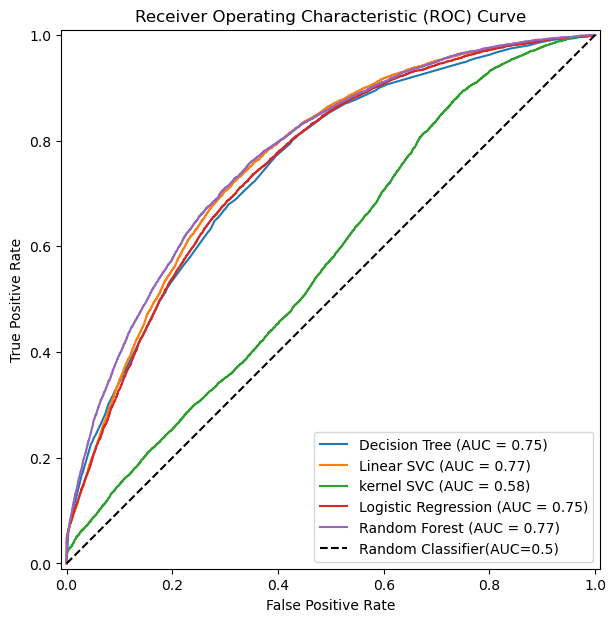

In [66]:
#Graph 1: Roc Curve

fig_1, ax_1 = plt.subplots()
roc = {}
plot_random = False #This is just to make sure that the random classifier is only plotted once

#Plot the ROC curve for each classifier
for name , prob_score , y_val in prob_scores:
    if name == 'Random Forest': #Only plot the random classifier once at the end
        plot_random = True  
    roc[name] = RocCurveDisplay.from_predictions(y_val, prob_score , plot_chance_level=plot_random, ax=ax_1,name=name,chance_level_kw={'label':'Random Classifier(AUC=0.5)'})
ax_1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax_1.set_xlabel('False Positive Rate')
ax_1.set_ylabel('True Positive Rate')
fig_1.set_size_inches(7,7)
plt.savefig('roc_curve_best.png')


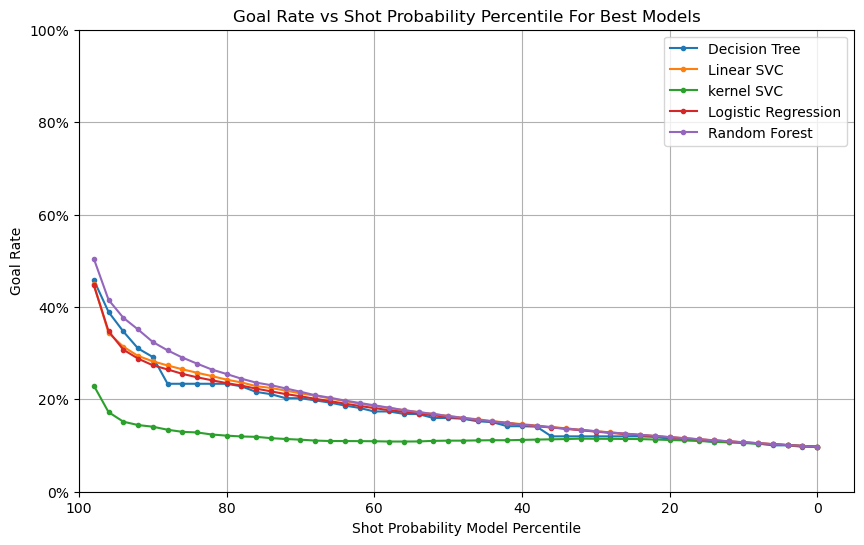

In [69]:
#Graph 2: Goal Rate as a Function of Shot Probability Model Percentile

# Calculate the percentiles for the shot probabilities for all models
percentile_bins = np.arange(0, 100, 2)
percentiles = {}
for name, prob_score,_ in prob_scores:
    percentile_data = np.percentile(prob_score , percentile_bins)
    percentiles[name] = percentile_data


# Calculate the goal rates for each percentile for all models
goal_rates = {}
for name, prob_score,y_val in prob_scores:
    goal_rates[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        goal_rates[name].append(y_val[mask].mean())


# Plot the goal rate as a function of the shot probability model percentile for all models

fig_2, ax_2 = plt.subplots()
for name, goal_rate in goal_rates.items():
    ax_2.plot(percentile_bins, goal_rate, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Goal Rate')
plt.title('Goal Rate vs Shot Probability Percentile For Best Models')
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, -5)
fig_2.set_size_inches(10,6)
plt.show()
fig_2.savefig('best_goal_rate_vs_shot_probability_percentile.png')

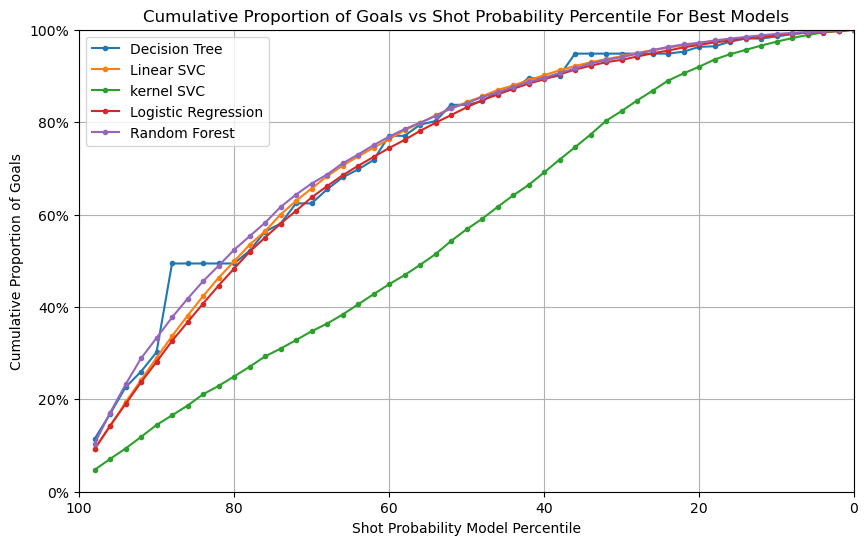

In [70]:
# Graph 3: Cumulative Proportion of Goals as a Function of Shot Probability Model Percentile 

# Calculate the cumulative goal percentage for each percentile for all models
cumulative_goal_proportions = {}
for name, prob_score, y_val in prob_scores:
    cumulative_goal_proportions[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        cumulative_goal_proportions[name].append(y_val[mask].sum() / y_val.sum())


# Plot the cumulative proportion of goals as a function of the shot probability model percentile for all models
fig_3, ax_3 = plt.subplots()
for name, cumulative_goal_proportion in cumulative_goal_proportions.items():
    ax_3.plot(percentile_bins, cumulative_goal_proportion, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Cumulative Proportion of Goals')
plt.title('Cumulative Proportion of Goals vs Shot Probability Percentile For Best Models')
plt.grid(True)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, 0)
plt.legend()
fig_3.set_size_inches(10,6)
plt.show()
fig_3.savefig('best_cumulative_proportion_of_goals_vs_shot_probability_percentile.png')

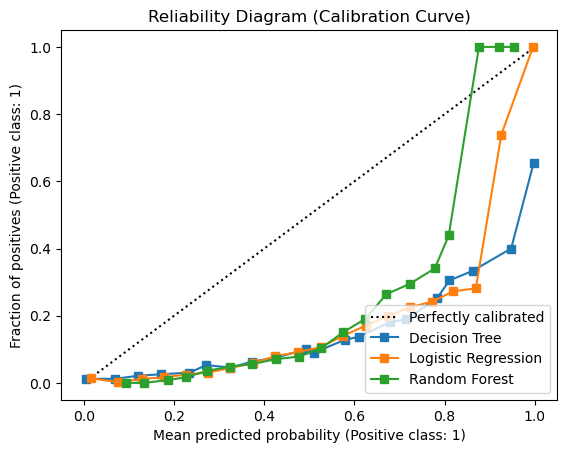

In [73]:
from sklearn.preprocessing import MinMaxScaler
# Graph 4: Calibration Curve
fig_4,ax_4 = plt.subplots()
#Plot the calibration curve for each classifier
scaler = MinMaxScaler()
for name, prob_score, y_val in prob_scores:
    if name in ['Random Forest','Decision Tree','Logistic Regression']:
        CalibrationDisplay.from_predictions(y_val, prob_score, n_bins=20, strategy='uniform',ax=ax_4,name=name)
plt.title('Reliability Diagram (Calibration Curve)')
plt.show()
fig_4.savefig('calibration_curve_best.png')



In [43]:
# Log the models to wandb
from ift6758.data.data_logger import DataLogger
api_key = os.getenv("WANDB_API_KEY") #REMEMBER TO SET YOUR API KEY IN THE ENVIRONMENT VARIABLES BUT NOT PUSH IT TO GITHUB
logger = DataLogger(project_name="IFT6758.2024-B08",entity='team08',group = 'log_best_models',API_KEY=api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\gogig\_netrc


In [45]:
#Collect the model paths as list of tuples (path,name)
model_paths = [(model_3_path,'Decision_Tree'),(model_4_path,'Linear_SVC'),(model_5_path,'Kernel_SVC'),(model_6_path,'Logistic_Regression'),(model_7_path,'Random_Forest')]
logger.log_models(model_paths)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.
